In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


sns.set(style='whitegrid', font_scale=1.3)
%matplotlib inline

## Small intro
In this notebook I try to solve binary classification problem. I want to create model with best params to predict wheteher job ad is real or fake. 

To achieve good result I preprocess initial text features and add new ones.

Additionally, I want to find out most important features for my model.

# Explore data

In [2]:
data = pd.read_csv('fake_job_postings.csv', index_col='job_id')
data.shape

(17880, 17)

In [3]:
data.head(4)

title            location  \
job_id                                                                  
1                                Marketing Intern    US, NY, New York   
2       Customer Service - Cloud Video Production      NZ, , Auckland   
3         Commissioning Machinery Assistant (CMA)       US, IA, Wever   
4               Account Executive - Washington DC  US, DC, Washington   

       department salary_range  \
job_id                           
1       Marketing          NaN   
2         Success          NaN   
3             NaN          NaN   
4           Sales          NaN   

                                          company_profile  \
job_id                                                      
1       We're Food52, and we've created a groundbreaki...   
2       90 Seconds, the worlds Cloud Video Production ...   
3       Valor Services provides Workforce Solutions th...   
4       Our passion for improving quality of life thro...   

                                              description  \
job_id                                                      
1       Food52, a fast-growing, James Beard Award-winn...   
2       Organised - Focused - Vibrant - Awesome!Do you...   
3       Our client, located in Houston, is actively se...   
4       THE COMPANY: ESRI – Environmental Systems Rese...   

                                             requirements  \
job_id                                                      
1       Experience with content management systems a m...   
2       What we expect from you:Your key responsibilit...   
3       Implement pre-commissioning and commissioning ...   
4       EDUCATION: Bachelor’s or Master’s in GIS, busi...   

                                                 benefits  telecommuting  \
job_id                                                                     
1                                                     NaN              0   
2       What you will get from usThrough being part of...              0   
3                                                     NaN              0   
4       Our culture is anything but corporate—we have ...              0   

        has_company_logo  has_questions employment_type required_experience  \
job_id                                                                        
1                      1              0           Other          Internship   
2                      1              0       Full-time      Not Applicable   
3                      1              0             NaN                 NaN   
4                      1              0       Full-time    Mid-Senior level   

       required_education                   industry          function  \
job_id                                                                   
1                     NaN                        NaN         Marketing   
2                     NaN  Marketing and Advertising  Customer Service   
3                     NaN                        NaN               NaN   
4       Bachelor's Degree          Computer Software             Sales   

        fraudulent  
job_id              
1                0  
2                0  
3                0  
4                0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17880 entries, 1 to 17880
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   telecommuting        17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

##### Count NaN per column in %

In [5]:
(data.isna().sum() / data.shape[0]).sort_values(ascending=False)

salary_range           0.839597
department             0.645805
required_education     0.453300
benefits               0.403244
required_experience    0.394295
function               0.361018
industry               0.274217
employment_type        0.194128
company_profile        0.185011
requirements           0.150727
location               0.019351
description            0.000056
fraudulent             0.000000
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
title                  0.000000
dtype: float64

In [6]:
data.nunique() 

title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

In [7]:
print('fraudulent == 1 count {} or {:.2f}% from all data'.format(
    data['fraudulent'].sum(), 
    data['fraudulent'].sum() / data.shape[0] * 100)
     )

fraudulent == 1 count 866 or 4.84% from all data


## Feature mining

### Location
Extract country, state and city info from location columns

In [8]:
data['location'] = data['location'].fillna(',,')
data['location'] = data['location'].apply(lambda x: x if len(x.split(',')) >= 3 else x + ',,')

# Add region features
data['country'] = data['location'].apply(lambda x: x.split(',')[0])
data['state'] = data['location'].apply(lambda x: x.split(',')[1])
data['city'] = data['location'].apply(lambda x: x.split(',')[2])

data.drop(columns=['location'], inplace=True)

### Text data

Extract word count and length fo the whole text description for each text column.

In [9]:
text_columns = ['title', 'company_profile', 'description', 'requirements', 'benefits']
num_col = []
name_col = []

# Добавим признаки длины текста
for col in text_columns:
    data['len_' + col] = data[col].fillna('').apply(lambda x: len(x))
    data['cnt_' + col] = data[col].fillna('').apply(lambda x: len(x.split()))
    
    num_col.append('len_' + col)
    num_col.append('cnt_' + col)
    name_col.append(col + ' length')
    name_col.append(col + ' count')

data.drop(columns=text_columns, inplace=True)

## Visualization

Let\`s explore our data!

In [10]:
positive = data[data['fraudulent'] == 1]
negative = data[data['fraudulent'] == 0]

fraud_c = '#f7714f'
real_c = '#4fe9f7'

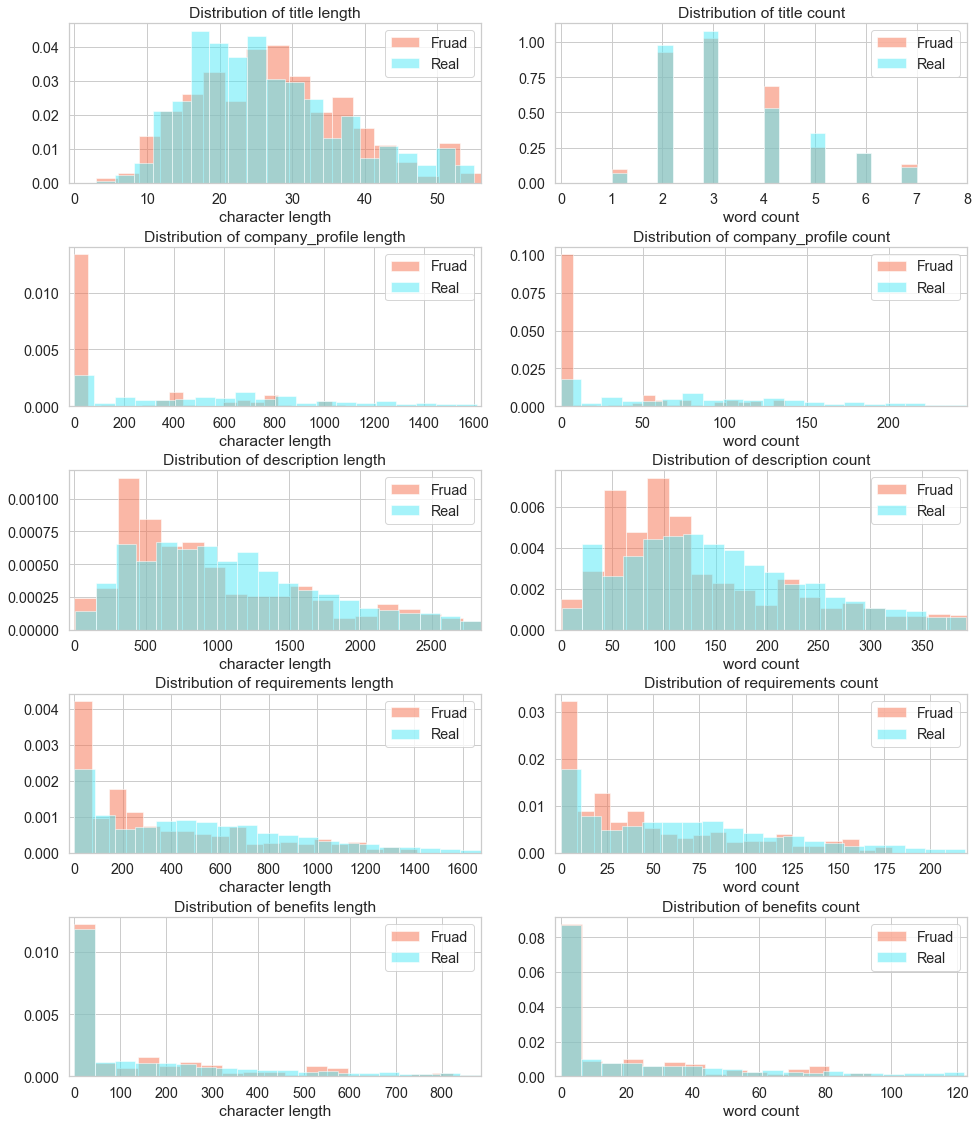

In [15]:
fig, axes = plt.subplots(5, 2, figsize=(14, 16))
fig.tight_layout(pad=3.5)
legend = {'cnt' : 'word count', 'len' : 'character length'}

for ax, col, name in zip(axes.flat, num_col, name_col):
    ax.hist(positive[positive[col] < positive[col].quantile(0.95)][col], bins=20, alpha=0.5, density=True, color=fraud_c)
    ax.hist(negative[negative[col] < negative[col].quantile(0.95)][col], bins=20, alpha=0.5, density=True, color=real_c)
    
    ax.set_title('Distribution of {}'.format(name))
    ax.legend(['Fruad', 'Real'])
    
    ax.set_xlim([- negative[col].quantile(0.95) / 70, negative[col].quantile(0.95)])
    ax.set_xlabel(legend[col[:3]])

#### There are 2 columns with a big difference: requirements and company_profile
I suppose these features will have a big impact on fraudulent prediction model

In [16]:
cols = ['required_education', 'required_experience', 'employment_type']
legend = {0: 'Real', 1: 'Fraud'}
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=cols,
    shared_yaxes=True,
)

colors = [real_c, fraud_c]

for idx, name in zip(range(1, 4), cols):
    for fraud, color in zip((0, 1), colors):
        if name != 'required_education':
            show_leg = False
        else:
            show_leg=True
            
        fig.add_trace(go.Histogram(
            x=data[data['fraudulent'] == fraud][name],
            histnorm='percent',
            name=legend[fraud], 
            xbins=dict(start=-1, end=6, size=1),
            marker_color=color,
            opacity=0.8,
            showlegend=show_leg
        ), 
        1, idx)

fig.update_layout(
    height=500, width=1000,
    #legend_title_text='Fraud',
    yaxis_title_text='Percent', 
    bargap=0.2, 
    bargroupgap=0.1,
    xaxis = dict(tickmode = 'linear', tick0 = -1, dtick = 1), 
)

fig.show()

There is a small difference in required_education. Fraud ads ussually have unspecified in this feature.

### Prepare cotegorical columns
Use integer labels. Fill NaN with zero value.

In [182]:
categorical_col = [
    'department', 'salary_range', 'employment_type', 
    'required_experience', 'required_education', 
    'industry', 'function',
    'country', 'state', 'city'
]

for cat in categorical_col:
    val = set(data[cat].values)
    category_mapping = dict(zip(val, range(len(val))))
    
    data[cat] = data[cat].fillna(np.nan).apply(lambda x: category_mapping[x])

### Pearson Correlation

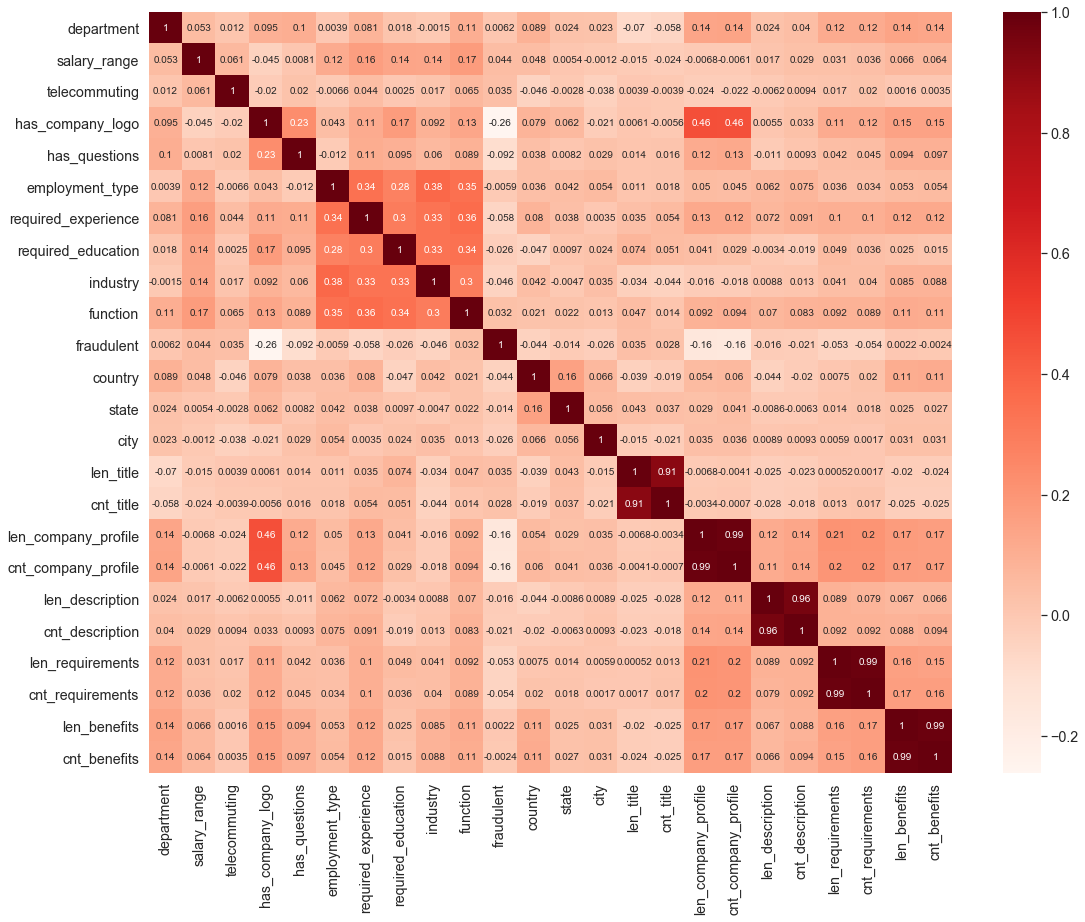

In [183]:
plt.figure(figsize=(18,14))

cor = data.corr()

sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

plt.show()

#### There are no features with a strong correlation with target column (fraudulent) 

# Predict the fraudulent

In [219]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

### As mentioned before, the dataset has unbalanced classes.

In [209]:
# Class weigths
positive = data[data['fraudulent'] == 1].shape[0]
negative = data[data['fraudulent'] == 0].shape[0]

class_weights = {0: 1, 1: negative / positive}

In [228]:
target = data['fraudulent']
features = data.drop(columns=['fraudulent'])
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0) # Split the data

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

assert scaled.mean() < 1e-6 and (scaled.std() - 1) < 1e-6

sc_x_train, sc_x_test, sc_y_train, sc_y_test = train_test_split(features, target, test_size=0.3, random_state=0)

In [230]:
# Balance
tmp = x_test
tmp['ans'] = y_test

x_test = pd.concat([tmp, tmp[tmp.ans == 1].sample(5100, replace=True)])
y_test = tmp['ans']
x_test = tmp.drop(columns = ['ans'])

In [231]:
def calculate_metrics(pred, real):
    tp = (pred[real == 1] == 1).sum()
    fp = (pred[real == 0] == 1).sum()
    fn = (pred[real == 1] == 0).sum()

    accuracy = (pred == real).sum() / real.shape[0]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

In [255]:
def train_and_evaluate_model(classifier, x_train_, y_train_, x_test_, y_test_):
    model = classifier
    
    model.fit(x_train_, y_train_)
    predicted = model.predict(x_test_)
    
    print(print("Accuracy {} \nPrecision {}\nRecall {}\nF1 {}".format(*calculate_metrics(predicted, y_test_))))
    
    return predicted, model

#### LogisticRegression (baseline)

In [262]:
predicted, LogReg = train_and_evaluate_model(
    LogisticRegression(class_weight='balanced',  solver='liblinear'),
    x_train,
    y_train,
    x_test,
    y_test
)

Accuracy 0.7824384787472036 
Precision 0.13509316770186336
Recall 0.7665198237885462
F1 0.2297029702970297
None


Good accuracy, but F1 is only 0.22

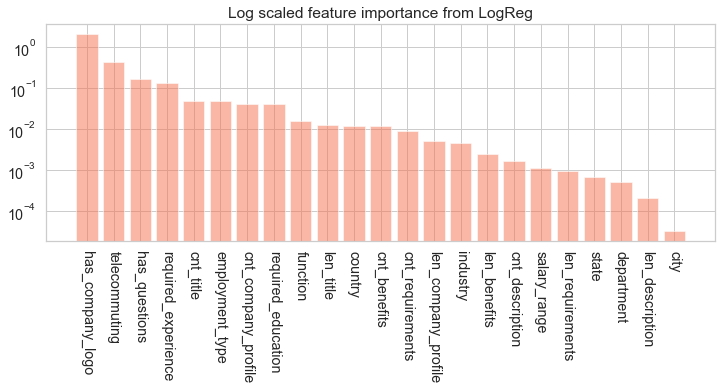

In [333]:
plt.figure(figsize=(12, 4))

coef = pd.DataFrame(columns=['cat', 'coef'])
coef['cat'] = data.drop(columns=['fraudulent']).columns.values
coef['coef'] = abs(LogReg.coef_[0])
coef.sort_values(by='coef', inplace=True, ascending=False)

plt.bar(coef['cat'], coef['coef'], color=fraud_c, alpha=0.5)

plt.title('Log scaled feature importance from LogReg')
plt.yscale('log')
plt.xticks(rotation=-90) 
plt.show()

The most significant impact from logo, telecomuting, has_questions and required_experience.

#### Gradient boosting

In [325]:
# Catboost
catboost_pred, catboost_model = train_and_evaluate_model(
    CatBoostClassifier(
        num_trees = 100,
        verbose=0, 
        class_weights=list(class_weights.values())
    ),
    x_train,
    y_train,
    x_test,
    y_test
)

Accuracy 0.964951528709918 
Precision 0.5575221238938053
Recall 0.8325991189427313
F1 0.6678445229681979
None


In [326]:
# XGBoost
predicted, XGB_model = train_and_evaluate_model(
    XGBClassifier(
        num_trees=100,
        class_weights=list(class_weights.values())
    ),
    x_train,
    y_train,
    x_test,
    y_test
)

Accuracy 0.9850857568978374 
Precision 0.9152542372881356
Recall 0.7136563876651982
F1 0.801980198019802
None


#### What a great performace!
We have achieved 0.98 accuracy and 0.80 F1 score

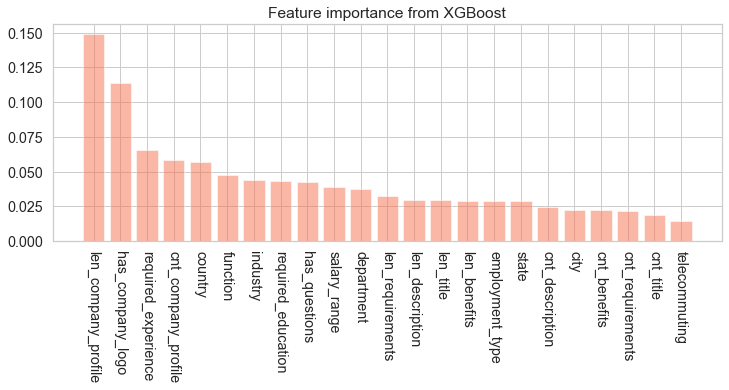

In [332]:
plt.figure(figsize=(12, 4))

coef = pd.DataFrame(columns=['cat', 'coef'])
coef['cat'] = data.drop(columns=['fraudulent']).columns.values
coef['coef'] = XGB_model.feature_importances_
coef.sort_values(by='coef', inplace=True, ascending=False)

plt.bar(coef['cat'], coef['coef'], color=fraud_c, alpha=0.5)

plt.title('Feature importance from XGBoost')
plt.xticks(rotation=-90) 
plt.show()

Finally, we got slightly different feature importance. The most important features for boosting were info about company (company_profile, has_company_logo, cnt_company_profile), as well as required experience. As we have seen before required_experience have had a different distribution for fraud and real ads.

### Try GridSearch to get best params

In [273]:
params = {'num_trees': [75, 100, 150], 'depth': [4, 6], 'verbose': [0]}

grid_search = GridSearchCV(XGBClassifier(), params)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [274]:
print("Accuracy {} \nPrecision {}\nRecall {}\nF1 {}".format(
    *calculate_metrics(grid_search.best_estimator_.predict(x_test), y_test))
     )

Accuracy 0.9839671886651753 
Precision 0.9122807017543859
Recall 0.6872246696035242
F1 0.7839195979899498


Unfortunately, we haven\`t improved score. So, I suppose initial params were good enought.

### Conclusion

I tried Logistic Regression as a baseline. The model\`s performance: 0.78 accuracy, 0.22 F1.

The best score was from XGB_classifier (hahaha gradient boosting go brrrrr...). The model\`s performance: 0.98 accuracy, 0.80 F1.

Fake ads ussually have poor company description and unspecify required experience.